In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Clean Raw Data

In [3]:
# full_df = pd.read_csv("LD2011_2014.txt", sep=";", index_col=0, parse_dates=True, decimal=",")

In [4]:
# full_df = full_df[full_df['MT_370'] > 0].copy()
# full_df = full_df.resample('h').mean() / 4

In [5]:
# full_df.to_csv('electricity_demand_timeseries.csv')

In [6]:
full_df = pd.read_csv('recitations_data_electricity_demand_timeseries.csv', index_col=0, parse_dates=True)
T = 132**2
train_data = full_df.iloc[:T, :]
test_data = full_df.iloc[T:T+24, :]

In [7]:
print(f"shape of data {full_df.shape}")
print(f"Time series use Trai points:{train_data.shape}\nTest data points:{test_data.shape}")
print(f"shape of data {full_df['MT_370'].describe()}")
print(f"shape of data {full_df['MT_370'].info()}")

shape of data (17521, 370)
Time series use Trai points:(17424, 370)
Test data points:(24, 370)
shape of data count    17491.000000
mean      4372.355281
std        984.730292
min         94.594595
25%       3820.608108
50%       4459.459459
75%       5054.054054
max       7114.864865
Name: MT_370, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 17521 entries, 2013-01-01 00:00:00 to 2015-01-01 00:00:00
Series name: MT_370
Non-Null Count  Dtype  
--------------  -----  
17491 non-null  float64
dtypes: float64(1)
memory usage: 273.8 KB
shape of data None


## SSA

Goal: Generate forecasts for `MT_370` using data from its own time series

### Step 1: Generate the Page Matrix

Be sure to fill any missing values with 0, and keep track of missing data

In [10]:
def page_matrix(ts, L):
  T = len(ts)
  page_matrix = np.zeros((L, int(T/L)))
  for t in range(T):
    i = t % L
    j = int(t/L)
    page_matrix[i, j] = ts[t]
  return page_matrix

In [11]:
# j = int(1/17424)
# print(j)

# j = (1%17424)
# print(j)

# j = (1//17424)
# print(j)

In [12]:
L = 132
null_idx = train_data['MT_370'].isna()
rho_hat = 1 - (sum(null_idx) / len(train_data))
ts = train_data['MT_370'].fillna(0).to_numpy()

SSA_P = page_matrix(ts, L)

In [13]:
rho_hat

0.9982782369146006

### Step 2: Perform Singular Value Thresholding

Select $r$ which captures 99% of energy

In [15]:
## SVD
u, s, vh = np.linalg.svd(SSA_P)

In [16]:
# Select r
for r in range(len(s)):
  if np.sum(np.square(s[:r])) / np.sum(np.square(s)) > 0.99:
    break
r

4

In [17]:
s_truncated = np.zeros((u.shape[0], vh.shape[0]))
s_truncated[:r, :r] = np.diag(s[:r])

SSA_P_hat = (u @ s_truncated @ vh) / rho_hat

### Step 3: Learn betas for prediction:

Use the first $L-1$ rows of the denoised matrix to predict the last row of the original matrix

In [19]:
Phi = SSA_P_hat[:-1, :].T
Y = SSA_P[-1, :]

betas_SSA = np.linalg.pinv(Phi) @ Y

### Step 4: Apply betas to do short-term forecasting

No need to update the model with each iteration

In [21]:
test_estimates_SSA = []

full_ts = full_df['MT_370'].fillna(0).to_numpy()
for t in range(len(train_data), len(train_data) + len(test_data)):
  test_estimate = np.dot(betas_SSA, full_ts[t-L + 1:t])
  test_estimates_SSA.append(test_estimate)

test_estimates_SSA = pd.Series(test_estimates_SSA, index=test_data.index)

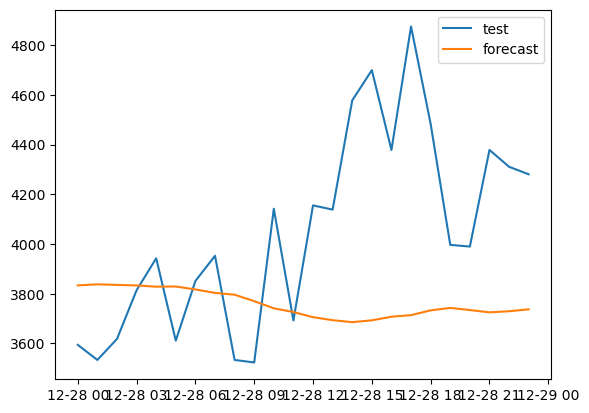

In [22]:
# plt.plot(train_data['MT_370'][-30:-1], label='train')
plt.plot(test_data['MT_370'], label='test')
plt.plot(test_estimates_SSA, label='forecast')
plt.legend()
plt.show()

In [23]:
## Compute MSE
ssa_error = np.mean(np.square(test_data['MT_370'] - test_estimates_SSA))
print(f"SSA ERROR :{ssa_error}")

SSA ERROR :263691.59772114287


## mSSA

Goal: Generate forecasts for `MT_370`, using training data from itself and other time series.

### Step 1: Generate the Page Matrix

Be sure to fill any missing values with 0, and keep track of missing data

Before, we used L = 132. To keep the Page Matrix nicely shaped and still using all of the data, we'll use a new L = 132 * 12 = 1584. This will ensure that our Page Matrix is close enough to being square

In [26]:
def stacked_page_matrix(ts_list, L):
  T = len(ts_list[0])
  num_ts = len(ts_list)
  stacked_page_matrix = np.zeros((L, int(T * num_ts/L)))
  for i, ts in enumerate(ts_list):
    stacked_page_matrix[:, i*int(T / L):(i+1)*int(T / L)] = page_matrix(ts, L)
  return stacked_page_matrix

In [27]:
null_idxs = [ train_data[i].isna() for i in train_data.columns]
total_obs = sum([sum(~null_idx) for null_idx in null_idxs])
rho_hat = total_obs / (train_data.size)


In [28]:
L = 132*12
ts_list = [train_data[i].fillna(0).to_numpy() for i in train_data.columns]
mSSA_P = stacked_page_matrix(ts_list, L)

In [29]:
# Original data shape
print('Original Data Shape:')
print(f"shape of data {full_df.shape}")
print(f"Time series use Train points:{train_data.shape}\nTest data points:{test_data.shape}")
print(f"shape of data {full_df['MT_370'].describe()}")
print(f"shape of data {full_df['MT_370'].info()}")

print(f"Row:L={int(train_data.shape[0]/132 * 12)}; row T/L={int(train_data.shape[0])/1584*370}")

Original Data Shape:
shape of data (17521, 370)
Time series use Train points:(17424, 370)
Test data points:(24, 370)
shape of data count    17491.000000
mean      4372.355281
std        984.730292
min         94.594595
25%       3820.608108
50%       4459.459459
75%       5054.054054
max       7114.864865
Name: MT_370, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 17521 entries, 2013-01-01 00:00:00 to 2015-01-01 00:00:00
Series name: MT_370
Non-Null Count  Dtype  
--------------  -----  
17491 non-null  float64
dtypes: float64(1)
memory usage: 273.8 KB
shape of data None
Row:L=1584; row T/L=4070.0


In [30]:
pd.DataFrame(mSSA_P)

,0,1,2,3,4,5,6,7,8,9,...,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069
0,0.528765,0.475888,0.634518,0.713832,3.727792,4.203680,0.634518,0.475888,0.396574,3.807107,...,4310.810811,4682.432432,4429.729730,4890.540541,4212.837838,4148.648649,3699.324324,5472.972973,3969.594595,4652.027027
1,0.555203,0.396574,0.634518,0.793147,3.727792,4.045051,0.555203,0.555203,0.475888,3.886421,...,4355.405405,4548.648649,5009.459459,4385.135135,4074.324324,3986.486486,3888.513514,5243.243243,3935.810811,4331.081081
2,0.475888,0.396574,0.634518,0.713832,3.807107,3.886421,0.555203,0.396574,0.475888,3.965736,...,4102.702703,4860.810811,5143.243243,4191.891892,4125.000000,3925.675676,3932.432432,5858.108108,3787.162162,4837.837838
3,0.555203,0.396574,0.555203,0.793147,3.727792,3.965736,0.634518,0.475888,0.475888,3.965736,...,4191.891892,4578.378378,4786.486486,3939.189189,4388.513514,4135.135135,3611.486486,5341.216216,3871.621622,4290.540541
4,0.555203,0.475888,0.713832,0.713832,3.807107,3.886421,0.555203,0.475888,0.475888,3.886421,...,4132.432432,4608.108108,3968.918919,3894.594595,4496.621622,4601.351351,4158.783784,5770.270270,4233.108108,5155.405405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,0.396574,0.555203,0.158629,3.569162,3.886421,0.555203,0.237944,0.317259,3.569162,0.396574,...,3017.567568,4474.324324,4697.297297,5043.918919,4398.648649,3760.135135,5631.756757,3608.108108,5263.513514,3989.864865
1580,0.475888,0.555203,0.237944,3.648477,3.886421,0.555203,0.396574,0.237944,3.569162,0.475888,...,3047.297297,4221.621622,4637.837838,4469.594595,4371.621622,3925.675676,5168.918919,3648.648649,5445.945946,3871.621622
1581,0.396574,0.555203,0.634518,3.727792,3.807107,0.713832,0.475888,0.396574,3.886421,0.555203,...,3374.324324,4191.891892,5054.054054,4425.675676,4614.864865,4202.702703,4952.702703,4094.594595,4219.594595,3942.567568
1582,0.396574,0.634518,0.713832,3.727792,4.996827,0.475888,0.475888,0.475888,3.965736,0.555203,...,3864.864865,3983.783784,5054.054054,4074.324324,4560.810811,3760.135135,4496.621622,3753.378378,4905.405405,3570.945946


### Step 2: Perform Singular Value Thresholding

In [32]:
## SVD
u, s, vh = np.linalg.svd(mSSA_P)

In [33]:
# Select r
for r in range(len(s)):
  if np.sum(np.square(s[:r])) / np.sum(np.square(s)) > 0.99:
    break
r

6

In [34]:
s_truncated = np.zeros((u.shape[0], vh.shape[0]))
s_truncated[:r, :r] = np.diag(s[:r])

mSSA_P_hat = (u @ s_truncated @ vh) / rho_hat

### Step 3: Learn betas for prediction:

Use the first $L-1$ rows of the denoised matrix to predict the last row of the original matrix

In [36]:
Phi = mSSA_P_hat[:-1, :].T
Y = mSSA_P[-1, :]

betas_mSSA = np.linalg.pinv(Phi) @ Y

### Step 4: Apply betas to do short-term forecasting

No need to update the model with each iteration

In [38]:
test_estimates_mSSA = []

full_ts = full_df['MT_370'].fillna(0).to_numpy()
for t in range(len(train_data), len(train_data) + len(test_data)):
  test_estimate = np.dot(betas_mSSA, full_ts[t-L + 1:t])
  test_estimates_mSSA.append(test_estimate)

test_estimates_mSSA = pd.Series(test_estimates_mSSA, index=test_data.index)

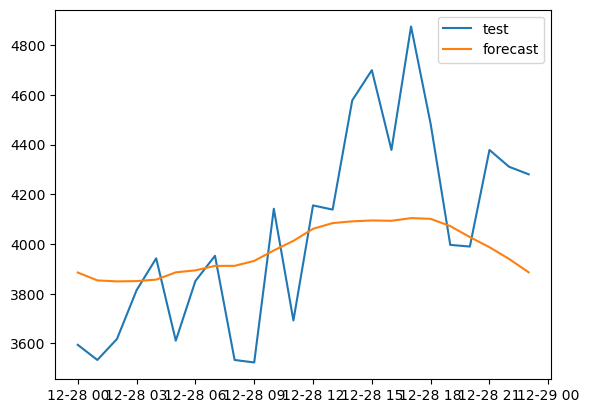

In [39]:
# plt.plot(train_data['MT_370'][-100:-1], label='train')
plt.plot(test_data['MT_370'], label='test')
plt.plot(test_estimates_mSSA, label='forecast')
plt.legend()

In [40]:
mssa_error = np.mean(np.square(test_data['MT_370'] - test_estimates_mSSA))
print(f"MSSA ERROR: {mssa_error}")
diff_mssa = mssa_error - ssa_error
print(f"difference btwn MSSA and SSA mse: {diff_mssa}")

MSSA ERROR: 110700.60380431607
difference btwn MSSA and SSA mse: -152990.9939168268


## tSSA (If time)

Same set up as mSSA, but uses a tensor instead of a stacked matrix

## Step 1: Generate Tensor

In [43]:
def page_tensor(ts_list, L):
  T = len(ts_list[0])
  N = len(ts_list)
  tensor = np.zeros((N, L, int(T/L)))
  for i, ts in enumerate(ts_list):
    tensor[i, :, :] = page_matrix(ts, L)
  return tensor

In [44]:
null_idxs = [ train_data[i].isna() for i in train_data.columns]
total_obs = sum([sum(~null_idx) for null_idx in null_idxs])
rho_hat = total_obs / (train_data.size)

In [45]:
L = 132
ts_list = [train_data[i].fillna(0).to_numpy() for i in train_data.columns]
tSSA_T = page_tensor(ts_list, L)

### Step 2: Tensor Decomposition

Use $r = 20$ for low-rank structure, but feel free to play with this hyperparameter

In [47]:
# !pip install tensorly
from tensorly.decomposition import parafac

In [48]:
r = 20
tSSA_T_hat = parafac(tSSA_T, rank=r, normalize_factors=True)
tSSA_T_hat = tSSA_T_hat.to_tensor() / rho_hat

In [49]:
tSSA_T.shape

(370, 132, 132)

### Step 3: Learn coefficients

In [51]:
Phi = np.hstack([tSSA_T_hat[i, :-1, :] for i in range(len(ts_list))]).T
Y = np.hstack([tSSA_T[i, -1, :] for i in range(len(ts_list))])

betas_tSSA = np.linalg.pinv(Phi) @ Y

### Step 4: Compute Predictions

In [53]:
test_estimates_tSSA = []

full_ts = full_df['MT_370'].fillna(0).to_numpy()
for t in range(len(train_data), len(train_data) + len(test_data)):
  test_estimate = np.dot(betas_tSSA, full_ts[t-L + 1:t])
  test_estimates_tSSA.append(test_estimate)

test_estimates_tSSA = pd.Series(test_estimates_tSSA, index=test_data.index)

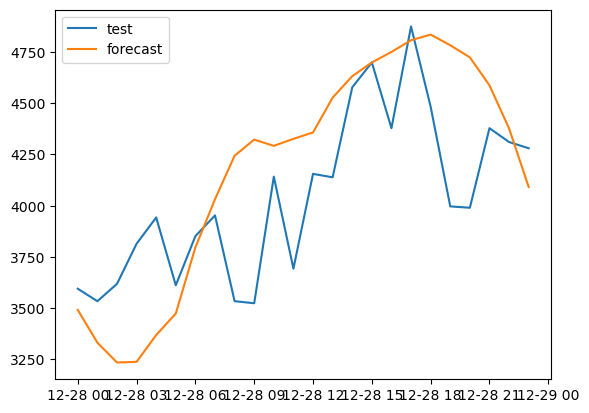

In [54]:
# plt.plot(train_data['MT_370'], label='train')
plt.plot(test_data['MT_370'], label='test')
plt.plot(test_estimates_tSSA, label='forecast')
plt.legend()

In [55]:
tssa_error = np.mean(np.square(test_data['MT_370'] - test_estimates_tSSA))
print(f"TSSA Error:{tssa_error}")

TSSA Error:173381.98160423632


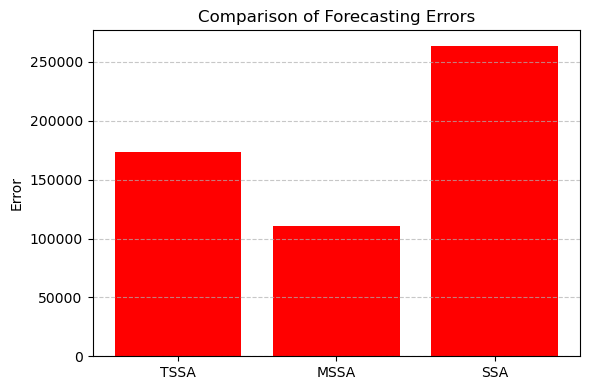

In [56]:
# Plot on bar

# Labels and values
labels = ['TSSA', 'MSSA', 'SSA']
errors = [tssa_error, mssa_error, ssa_error]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, errors, color='red')
plt.ylabel('Error')
plt.title('Comparison of Forecasting Errors')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()